In [17]:
from collections import defaultdict, Counter
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
from itertools import combinations, product
import scipy.stats as stats

In [2]:
# need affected/unaffected information
# these files can be found on sherlock
# '../data/v34.vcf.ped' = /scratch/PI/dpwall/DATA/iHART/vcf/v3.4/v34.vcf.ped
# '../data/ssc.ped' = /scratch/PI/dpwall/DATA/iHART/vcf/SSC/ssc.ped

ped_files = ['../data/v34.vcf.ped', '../data/ssc.ped']
# Affection (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()

for ped_file in ped_files:
    with open(ped_file, 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            if len(pieces) >= 6:
                fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
                child_id_to_affected[child_id] = disease_status
                child_id_to_sex[child_id] = sex

In [3]:
# for this analysis, we remove families with monozygotic multiples

monozygotic_multiple_families = set()
with open('../data/160826.iHART.db.query.csv', 'r') as f:
    next(f)
    for line in f:
        pieces = line.split(',')
        if 'MZ' in pieces[11]:
            monozygotic_multiple_families.add(pieces[3])
print('Mono multiples', len(monozygotic_multiple_families))

Mono multiples 96


In [18]:
chroms = [str(x) for x in range(1, 23)] #+ ['X']

ihart_family_sizes = [3, 4, 5, 6, 7]
ihart_phase_dir = '../phased_ihart'

ihart_quad_family_sizes = [4]
ihart_quad_phase_dir = '../phased_ihart_quad'

ssc_family_sizes = [4]
ssc_phase_dir = '../phased_ssc'


In [19]:
# filter families by various criteria

def pull_ok_families(phase_dir, family_sizes):

    # make sure we have data from every chromosome for each family
    family_to_chroms = defaultdict(set)
    family_to_individuals = dict()
    for chrom in chroms:
        print(chrom, end=' ')

        for j in family_sizes:
            try:
                with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, chrom, j), 'r') as f:
                    next(f) # skip header
                    for line in f:
                        pieces = line.strip().split('\t')
                        family_key = pieces[0]
                        family_to_chroms[family_key].add(chrom)
                        family_to_individuals[family_key] = pieces[1:(1+j)]
            except FileNotFoundError:
                print('File not found', 'chrom', chrom, 'family size', j)
            except StopIteration:
                print('File empty', 'chrom', chrom, 'family size', j)

    families_with_all_chroms = set([k for k, v in family_to_chroms.items() if len(v)==len(chroms)])
    print('Families with all chroms', len(families_with_all_chroms))
    print(Counter([len(v) for v in family_to_chroms.values()]))
    
    # some individuals in iHART have data on WB and LCL, we these families as well, since the phasing algorithm 
    # naively treated these samples as coming from different people - I need to go back and fix this
    families_with_lcl = set([x for x, inds in family_to_individuals.items() if len([y for y in inds if 'LCL' in y]) > 0])
    print('Families with LCL', len(families_with_lcl))
    
    families_to_include = dict([(x, family_to_individuals[x]) for x in families_with_all_chroms if x not in families_with_lcl and x.split('.')[0]  not in monozygotic_multiple_families])
    print('Final families', len(families_to_include))
    
    return families_to_include

ok_ihart_families = pull_ok_families(ihart_phase_dir, ihart_family_sizes)
ok_ihart_quad_families = pull_ok_families(ihart_quad_phase_dir, ihart_quad_family_sizes)
ok_ssc_families = pull_ok_families(ssc_phase_dir, ssc_family_sizes)



1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 Families with all chroms 880
Counter({22: 880})
Families with LCL 0
Final families 795
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 Families with all chroms 2049
Counter({22: 2049})
Families with LCL 0
Final families 1829
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 Families with all chroms 518
Counter({22: 518})
Families with LCL 0
Final families 518


In [23]:
def load_phase_data(phase_dir, family_sizes, families_to_include):
    sibpair_to_mat_match = defaultdict(int)
    sibpair_to_mat_mismatch = defaultdict(int)
    sibpair_to_pat_match = defaultdict(int)
    sibpair_to_pat_mismatch = defaultdict(int)

    for chrom in chroms:
        print(chrom, end=' ')

        # pull families
        family_to_individuals = dict()
        for j in family_sizes:
            with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, chrom, j), 'r')  as f: 
                next(f) # skip header
                for line in f:
                    pieces = line.strip().split('\t')
                    family_key = pieces[0]
                    if family_key in families_to_include.keys():
                        family_to_individuals[family_key] = pieces[1:(1+j)]


        # now read phase info
        for j in family_sizes:
            # load deletions
            with open('%s/chr.%s.familysize.%d.phased.txt' % (phase_dir, chrom, j), 'r')  as f:
                next(f) # skip header

                for line in f:
                    pieces = line.strip().split('\t')
                    family_key = pieces[0]
                    if family_key in families_to_include.keys():
                        inheritance_state = [int(x) for x in pieces[1:(2+(j*2))]]
                        start_pos, end_pos = [int(x) for x in pieces[(2+(j*2)):(4+(j*2))]]
                        length = end_pos - start_pos + 1

                        has_m1, has_m2, has_p1, has_p2 = [], [], [], []
                        children = family_to_individuals[family_key][2:]
                        if inheritance_state[-1] == 0:
                            for i, child in enumerate(children):
                                if inheritance_state[4+(2*i)] == 0:
                                    has_m1.append(child)
                                elif inheritance_state[4+(2*i)] == 1:
                                    has_m2.append(child)
                                if inheritance_state[5+(2*i)] == 0:
                                    has_p1.append(child)
                                elif inheritance_state[5+(2*i)] == 1:
                                    has_p2.append(child)
                                    
                        # matches
                        for c1, c2 in combinations(has_m1, 2):
                            sibpair_to_mat_match[(min(c1, c2), max(c1, c2))] += length
                        for c1, c2 in combinations(has_m2, 2):
                            sibpair_to_mat_match[(min(c1, c2), max(c1, c2))] += length
                        for c1, c2 in combinations(has_p1, 2):
                            sibpair_to_pat_match[(min(c1, c2), max(c1, c2))] += length
                        for c1, c2 in combinations(has_p2, 2):
                            sibpair_to_pat_match[(min(c1, c2), max(c1, c2))] += length
                            
                        # mismatches
                        for c1, c2 in product(has_m1, has_m2):
                            sibpair_to_mat_mismatch[(min(c1, c2), max(c1, c2))] += length
                        for c1, c2 in product(has_p1, has_p2):
                            sibpair_to_pat_mismatch[(min(c1, c2), max(c1, c2))] += length
    return sibpair_to_mat_match, sibpair_to_mat_mismatch, sibpair_to_pat_match, sibpair_to_pat_mismatch

print('iHART')
ihart_sibpair_to_mat_match, ihart_sibpair_to_mat_mismatch, ihart_sibpair_to_pat_match, ihart_sibpair_to_pat_mismatch = load_phase_data(ihart_phase_dir, ihart_family_sizes, ok_ihart_families)
print('iHART quad')
ihart_quad_sibpair_to_mat_match, ihart_quad_sibpair_to_mat_mismatch, ihart_quad_sibpair_to_pat_match, ihart_quad_sibpair_to_pat_mismatch = load_phase_data(ihart_quad_phase_dir, ihart_quad_family_sizes, ok_ihart_quad_families)
print('SSC')
ssc_sibpair_to_mat_match, ssc_sibpair_to_mat_mismatch, ssc_sibpair_to_pat_match, ssc_sibpair_to_pat_mismatch  = load_phase_data(ssc_phase_dir, ssc_family_sizes, ok_ssc_families)



iHART
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 iHART quad
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 SSC
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 

Removing 13 outliers
Removing 0 outliers
Removing 0 outliers


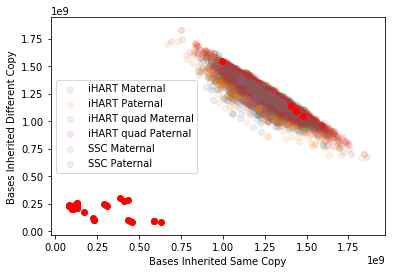

In [30]:
ihart_sibpairs = sorted(set(ihart_sibpair_to_mat_match.keys()) & set(ihart_quad_sibpair_to_mat_match.keys()))
ihart_mat_match = np.array([ihart_sibpair_to_mat_match[k] for k in ihart_sibpairs])
ihart_mat_mismatch = np.array([ihart_sibpair_to_mat_mismatch[k] for k in ihart_sibpairs])
ihart_pat_match = np.array([ihart_sibpair_to_pat_match[k] for k in ihart_sibpairs])
ihart_pat_mismatch = np.array([ihart_sibpair_to_pat_mismatch[k] for k in ihart_sibpairs])

plt.scatter(ihart_mat_match, ihart_mat_mismatch, alpha=0.1, label='iHART Maternal')
plt.scatter(ihart_pat_match, ihart_pat_mismatch, alpha=0.1, label='iHART Paternal')

ihart_quad_mat_match = np.array([ihart_quad_sibpair_to_mat_match[k] for k in ihart_sibpairs])
ihart_quad_mat_mismatch = np.array([ihart_quad_sibpair_to_mat_mismatch[k] for k in ihart_sibpairs])
ihart_quad_pat_match = np.array([ihart_quad_sibpair_to_pat_match[k] for k in ihart_sibpairs])
ihart_quad_pat_mismatch = np.array([ihart_quad_sibpair_to_pat_mismatch[k] for k in ihart_sibpairs])

plt.scatter(ihart_quad_mat_match, ihart_quad_mat_mismatch, alpha=0.1, label='iHART quad Maternal')
plt.scatter(ihart_quad_pat_match, ihart_quad_pat_mismatch, alpha=0.1, label='iHART quad Paternal')

ssc_sibpairs = sorted(ssc_sibpair_to_mat_match.keys())
ssc_mat_match = np.array([ssc_sibpair_to_mat_match[k] for k in ssc_sibpairs])
ssc_mat_mismatch = np.array([ssc_sibpair_to_mat_mismatch[k] for k in ssc_sibpairs])
ssc_pat_match = np.array([ssc_sibpair_to_pat_match[k] for k in ssc_sibpairs])
ssc_pat_mismatch = np.array([ssc_sibpair_to_pat_mismatch[k] for k in ssc_sibpairs])

plt.scatter(ssc_mat_match, ssc_mat_mismatch, alpha=0.1, label='SSC Maternal')
plt.scatter(ssc_pat_match, ssc_pat_mismatch, alpha=0.1, label='SSC Paternal')

plt.xlabel('Bases Inherited Same Copy')
plt.ylabel('Bases Inherited Different Copy')

ihart_outliers = (ihart_mat_mismatch < 0.5*pow(10, 9)) | (ihart_pat_mismatch < 0.5*pow(10, 9))
print('Removing %d outliers' % np.sum(ihart_outliers))

plt.scatter(ihart_mat_match[ihart_outliers], ihart_mat_mismatch[ihart_outliers], color='red')
plt.scatter(ihart_pat_match[ihart_outliers], ihart_pat_mismatch[ihart_outliers], color='red')
plt.scatter(ihart_quad_mat_match[ihart_outliers], ihart_quad_mat_mismatch[ihart_outliers], color='red')
plt.scatter(ihart_quad_pat_match[ihart_outliers], ihart_quad_pat_mismatch[ihart_outliers], color='red')

ihart_sibpairs = [ihart_sibpairs[i] for i in np.where(~ihart_outliers)[0]]
ihart_mat_match = ihart_mat_match[~ihart_outliers]
ihart_mat_mismatch = ihart_mat_mismatch[~ihart_outliers]
ihart_pat_match = ihart_pat_match[~ihart_outliers]
ihart_pat_mismatch = ihart_pat_mismatch[~ihart_outliers]
ihart_quad_mat_match = ihart_quad_mat_match[~ihart_outliers]
ihart_quad_mat_mismatch = ihart_quad_mat_mismatch[~ihart_outliers]
ihart_quad_pat_match = ihart_quad_pat_match[~ihart_outliers]
ihart_quad_pat_mismatch = ihart_quad_pat_mismatch[~ihart_outliers]

ihart_quad_outliers = (ihart_quad_mat_mismatch < 0.5*pow(10, 9)) | (ihart_quad_pat_mismatch < 0.5*pow(10, 9))
print('Removing %d outliers' % np.sum(ihart_quad_outliers))

plt.scatter(ihart_quad_mat_match[ihart_quad_outliers], ihart_quad_mat_mismatch[ihart_quad_outliers], color='red')
plt.scatter(ihart_quad_pat_match[ihart_quad_outliers], ihart_quad_pat_mismatch[ihart_quad_outliers], color='red')

ihart_mat_match = ihart_mat_match[~ihart_quad_outliers]
ihart_mat_mismatch = ihart_mat_mismatch[~ihart_quad_outliers]
ihart_pat_match = ihart_pat_match[~ihart_quad_outliers]
ihart_pat_mismatch = ihart_pat_mismatch[~ihart_quad_outliers]
ihart_quad_mat_match = ihart_quad_mat_match[~ihart_quad_outliers]
ihart_quad_mat_mismatch = ihart_quad_mat_mismatch[~ihart_quad_outliers]
ihart_quad_pat_match = ihart_quad_pat_match[~ihart_quad_outliers]
ihart_quad_pat_mismatch = ihart_quad_pat_mismatch[~ihart_quad_outliers]

ssc_outliers = (ssc_mat_mismatch < 0.5*pow(10, 9)) | (ssc_pat_mismatch < 0.5*pow(10, 9))
print('Removing %d outliers' % np.sum(ssc_outliers))

plt.scatter(ssc_mat_match[ssc_outliers], ssc_mat_mismatch[ssc_outliers], color='red')
plt.scatter(ssc_pat_match[ssc_outliers], ssc_pat_mismatch[ssc_outliers], color='red')

ssc_sibpairs = [ssc_sibpairs[i] for i in np.where(~ssc_outliers)[0]]
ssc_mat_match = ssc_mat_match[~ssc_outliers]
ssc_mat_mismatch = ssc_mat_mismatch[~ssc_outliers]
ssc_pat_match = ssc_pat_match[~ssc_outliers]
ssc_pat_mismatch = ssc_pat_mismatch[~ssc_outliers]

plt.legend()
plt.show()

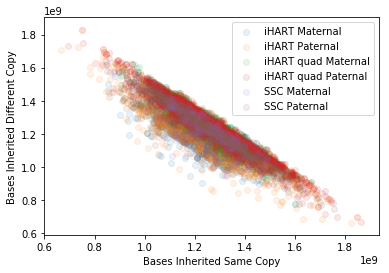

In [31]:
plt.scatter(ihart_mat_match, ihart_mat_mismatch, alpha=0.1, label='iHART Maternal')
plt.scatter(ihart_pat_match, ihart_pat_mismatch, alpha=0.1, label='iHART Paternal')

plt.scatter(ihart_quad_mat_match, ihart_quad_mat_mismatch, alpha=0.1, label='iHART quad Maternal')
plt.scatter(ihart_quad_pat_match, ihart_quad_pat_mismatch, alpha=0.1, label='iHART quad Paternal')

plt.scatter(ssc_mat_match, ssc_mat_mismatch, alpha=0.1, label='SSC Maternal')
plt.scatter(ssc_pat_match, ssc_pat_mismatch, alpha=0.1, label='SSC Paternal')

plt.xlabel('Bases Inherited Same Copy')
plt.ylabel('Bases Inherited Different Copy')

plt.legend()
plt.show()

In [32]:
ihart_mat = ihart_mat_match/(ihart_mat_match+ihart_mat_mismatch)
ihart_pat = ihart_pat_match/(ihart_pat_match+ihart_pat_mismatch)

ihart_quad_mat = ihart_quad_mat_match/(ihart_quad_mat_match+ihart_quad_mat_mismatch)
ihart_quad_pat = ihart_quad_pat_match/(ihart_quad_pat_match+ihart_quad_pat_mismatch)

ssc_mat = ssc_mat_match/(ssc_mat_match+ssc_mat_mismatch)
ssc_pat = ssc_pat_match/(ssc_pat_match+ssc_pat_mismatch)

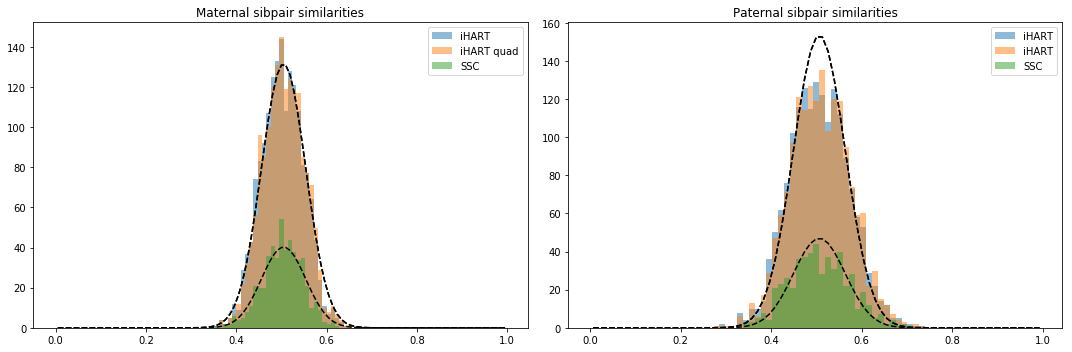

In [33]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
p = 0.5
n = (21+(2*42))
x_axis = np.arange(0, n)
plt.plot((x_axis+0.5)/n, len(ihart_mat)*stats.binom.pmf(x_axis, n, p), color='black', linestyle='--')
plt.plot((x_axis+0.5)/n, len(ihart_quad_mat)*stats.binom.pmf(x_axis, n, p), color='black', linestyle='--')
plt.plot((x_axis+0.5)/n, len(ssc_mat)*stats.binom.pmf(x_axis, n, p), color='black', linestyle='--')
plt.hist(ihart_mat, bins=x_axis/n, alpha=0.5, label='iHART')
plt.hist(ihart_quad_mat, bins=x_axis/n, alpha=0.5, label='iHART quad')
plt.hist(ssc_mat, bins=x_axis/n, alpha=0.5, label='SSC')
plt.legend()
plt.title('Maternal sibpair similarities')

plt.subplot(1, 2, 2)
n = (21+(2*28))
x_axis = np.arange(0, n)
plt.plot((x_axis+0.5)/n, len(ihart_pat)*stats.binom.pmf(x_axis, n, p), color='black', linestyle='--')
plt.plot((x_axis+0.5)/n, len(ihart_quad_pat)*stats.binom.pmf(x_axis, n, p), color='black', linestyle='--')
plt.plot((x_axis+0.5)/n, len(ssc_pat)*stats.binom.pmf(x_axis, n, p), color='black', linestyle='--')
plt.hist(ihart_pat, bins=x_axis/n, alpha=0.5, label='iHART')
plt.hist(ihart_quad_pat, bins=x_axis/n, alpha=0.5, label='iHART')
plt.hist(ssc_pat, bins=x_axis/n, alpha=0.5, label='SSC')
plt.legend()
plt.title('Paternal sibpair similarities')

plt.tight_layout()
plt.show()

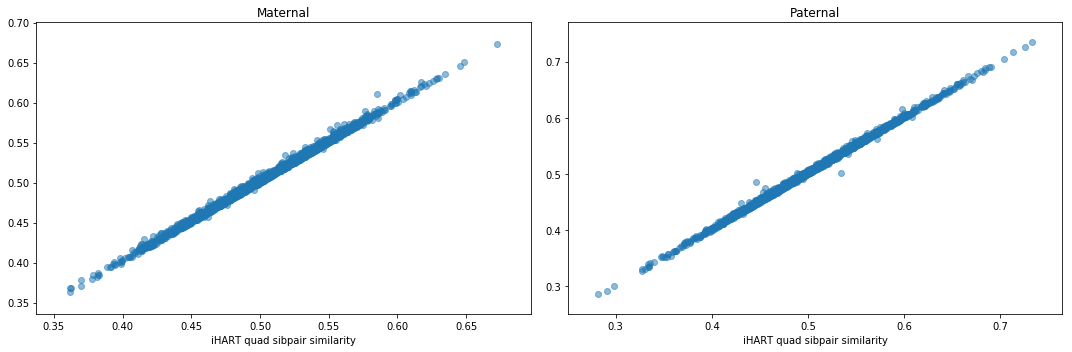

In [35]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(ihart_mat, ihart_quad_mat, alpha=0.5)
plt.title('Maternal')
plt.xlabel('iHART sibpair similarity')
plt.xlabel('iHART quad sibpair similarity')

plt.subplot(1, 2, 2)
plt.scatter(ihart_pat, ihart_quad_pat, alpha=0.5)
plt.title('Paternal')
plt.xlabel('iHART sibpair similarity')
plt.xlabel('iHART quad sibpair similarity')

plt.tight_layout()
plt.show()

In [42]:
# write to file

with open('sibpair_similarity_scores.txt', 'w+') as f:
    f.write('Sibling1\tSibling2\tDataset\tMaternal-Similarity\tPaternal-Similarity\n')
    for i, sibpair in enumerate(ssc_sibpairs):
        f.write('%s\t%s\t%s\t%f\t%f\n' % (sibpair[0], sibpair[1], 'SSC', ssc_mat, ssc_pat))
    for i, sibpair in enumerate(ihart_sibpairs):
        f.write('%s\t%s\t%s\t%f\t%f\n' % (sibpair[0], sibpair[1], 'iHART', ihart_mat, ihart_pat))
    

In [38]:
# write to file

with open('sibpair_similarity_scores_quad.txt', 'w+') as f:
    f.write('Sibling1\tSibling2\tDataset\tMaternal-Similarity\tPaternal-Similarity\n')
    for i, sibpair in enumerate(ssc_sibpairs):
        f.write('%s\t%s\t%s\t%f\t%f\n' % (sibpair[0], sibpair[1], 'SSC', ssc_mat[i], ssc_pat[i]))
    for i, sibpair in enumerate(ihart_sibpairs):
        f.write('%s\t%s\t%s\t%f\t%f\n' % (sibpair[0], sibpair[1], 'iHART quad', ihart_quad_mat[i], ihart_quad_pat[i]))
    